In [126]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import __version__
print("scikit-learn version "+str(__version__) + "(>= 0.18 required)")

scikit-learn version 0.18(>= 0.18 required)


# Statistical Analysis <small>on [alpine plants](./plants5.csv) dataset</small>

We load the data and perform several transformations. Notably, we:

1. Drop features with direct relationship to modeled variable `migration_m` (see `drop_features`)
2. Convert categorical features into [one-hot encoding](http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/). We must do this because although the data set already has converted certain categorical features into an encoding, the ordered encoding used (i.e. 1 = gravity, 2= wind for dispersal) gives arbitrary ordering to the data. This cannot be. We use one-hot encoding to alleviate this. 
3. We can choose whether to filter the data based on significance (the `signif_shift` field), but there's no documentation for that field so we forego that for now
4. Drop features with N/A or NaN (**we lose a good number of features this way**)

In [83]:
DROP_FEATS = 0 # 0 no, 1 yes. 0 = drop rows with N/A. 1 = drop columns with N/A

plants_master = pd.read_csv("plants5.csv")


drop_features = ["Taxon",
                 "migr_sterr_m", 
                 "shift + 2SE", 
                 'signif_shift',
                 "signif_shift2",
                 "dispmode01",
                 "DispModeEng", ## what is this
                 "shift + 2SE",
                ]

categorical_features = ["oceanity", "dispersal_mode", "BreedSysCode", "Grime"]

# one-hot encoding for categorical features:
plants = pd.get_dummies(plants_master, columns=categorical_features)

# drop features we don't want
features = plants.drop(drop_features, axis=1)

# drop features with n/a or NaN
beforenona = set(features.columns.values)
## axis = 1 drops columns with any NAs, axis = 0 drops rows with any NAs
features = features.dropna(axis=DROP_FEATS)
afternona  = set(features.columns.values)

# extract response variable from trimmed data
target   = features["migration_m"]
features.drop(["migration_m"], inplace=True, axis=1)

print("Processing complete:")
print("Number of Entries: " + str(len(features)))
print("Cols removed: " + str((beforenona-afternona)))
print("# Rows Removed: " + str(len(plants_master) - len(features)))

Processing complete:
Number of Entries: 20
Cols removed: set()
# Rows Removed: 113


## Plots:


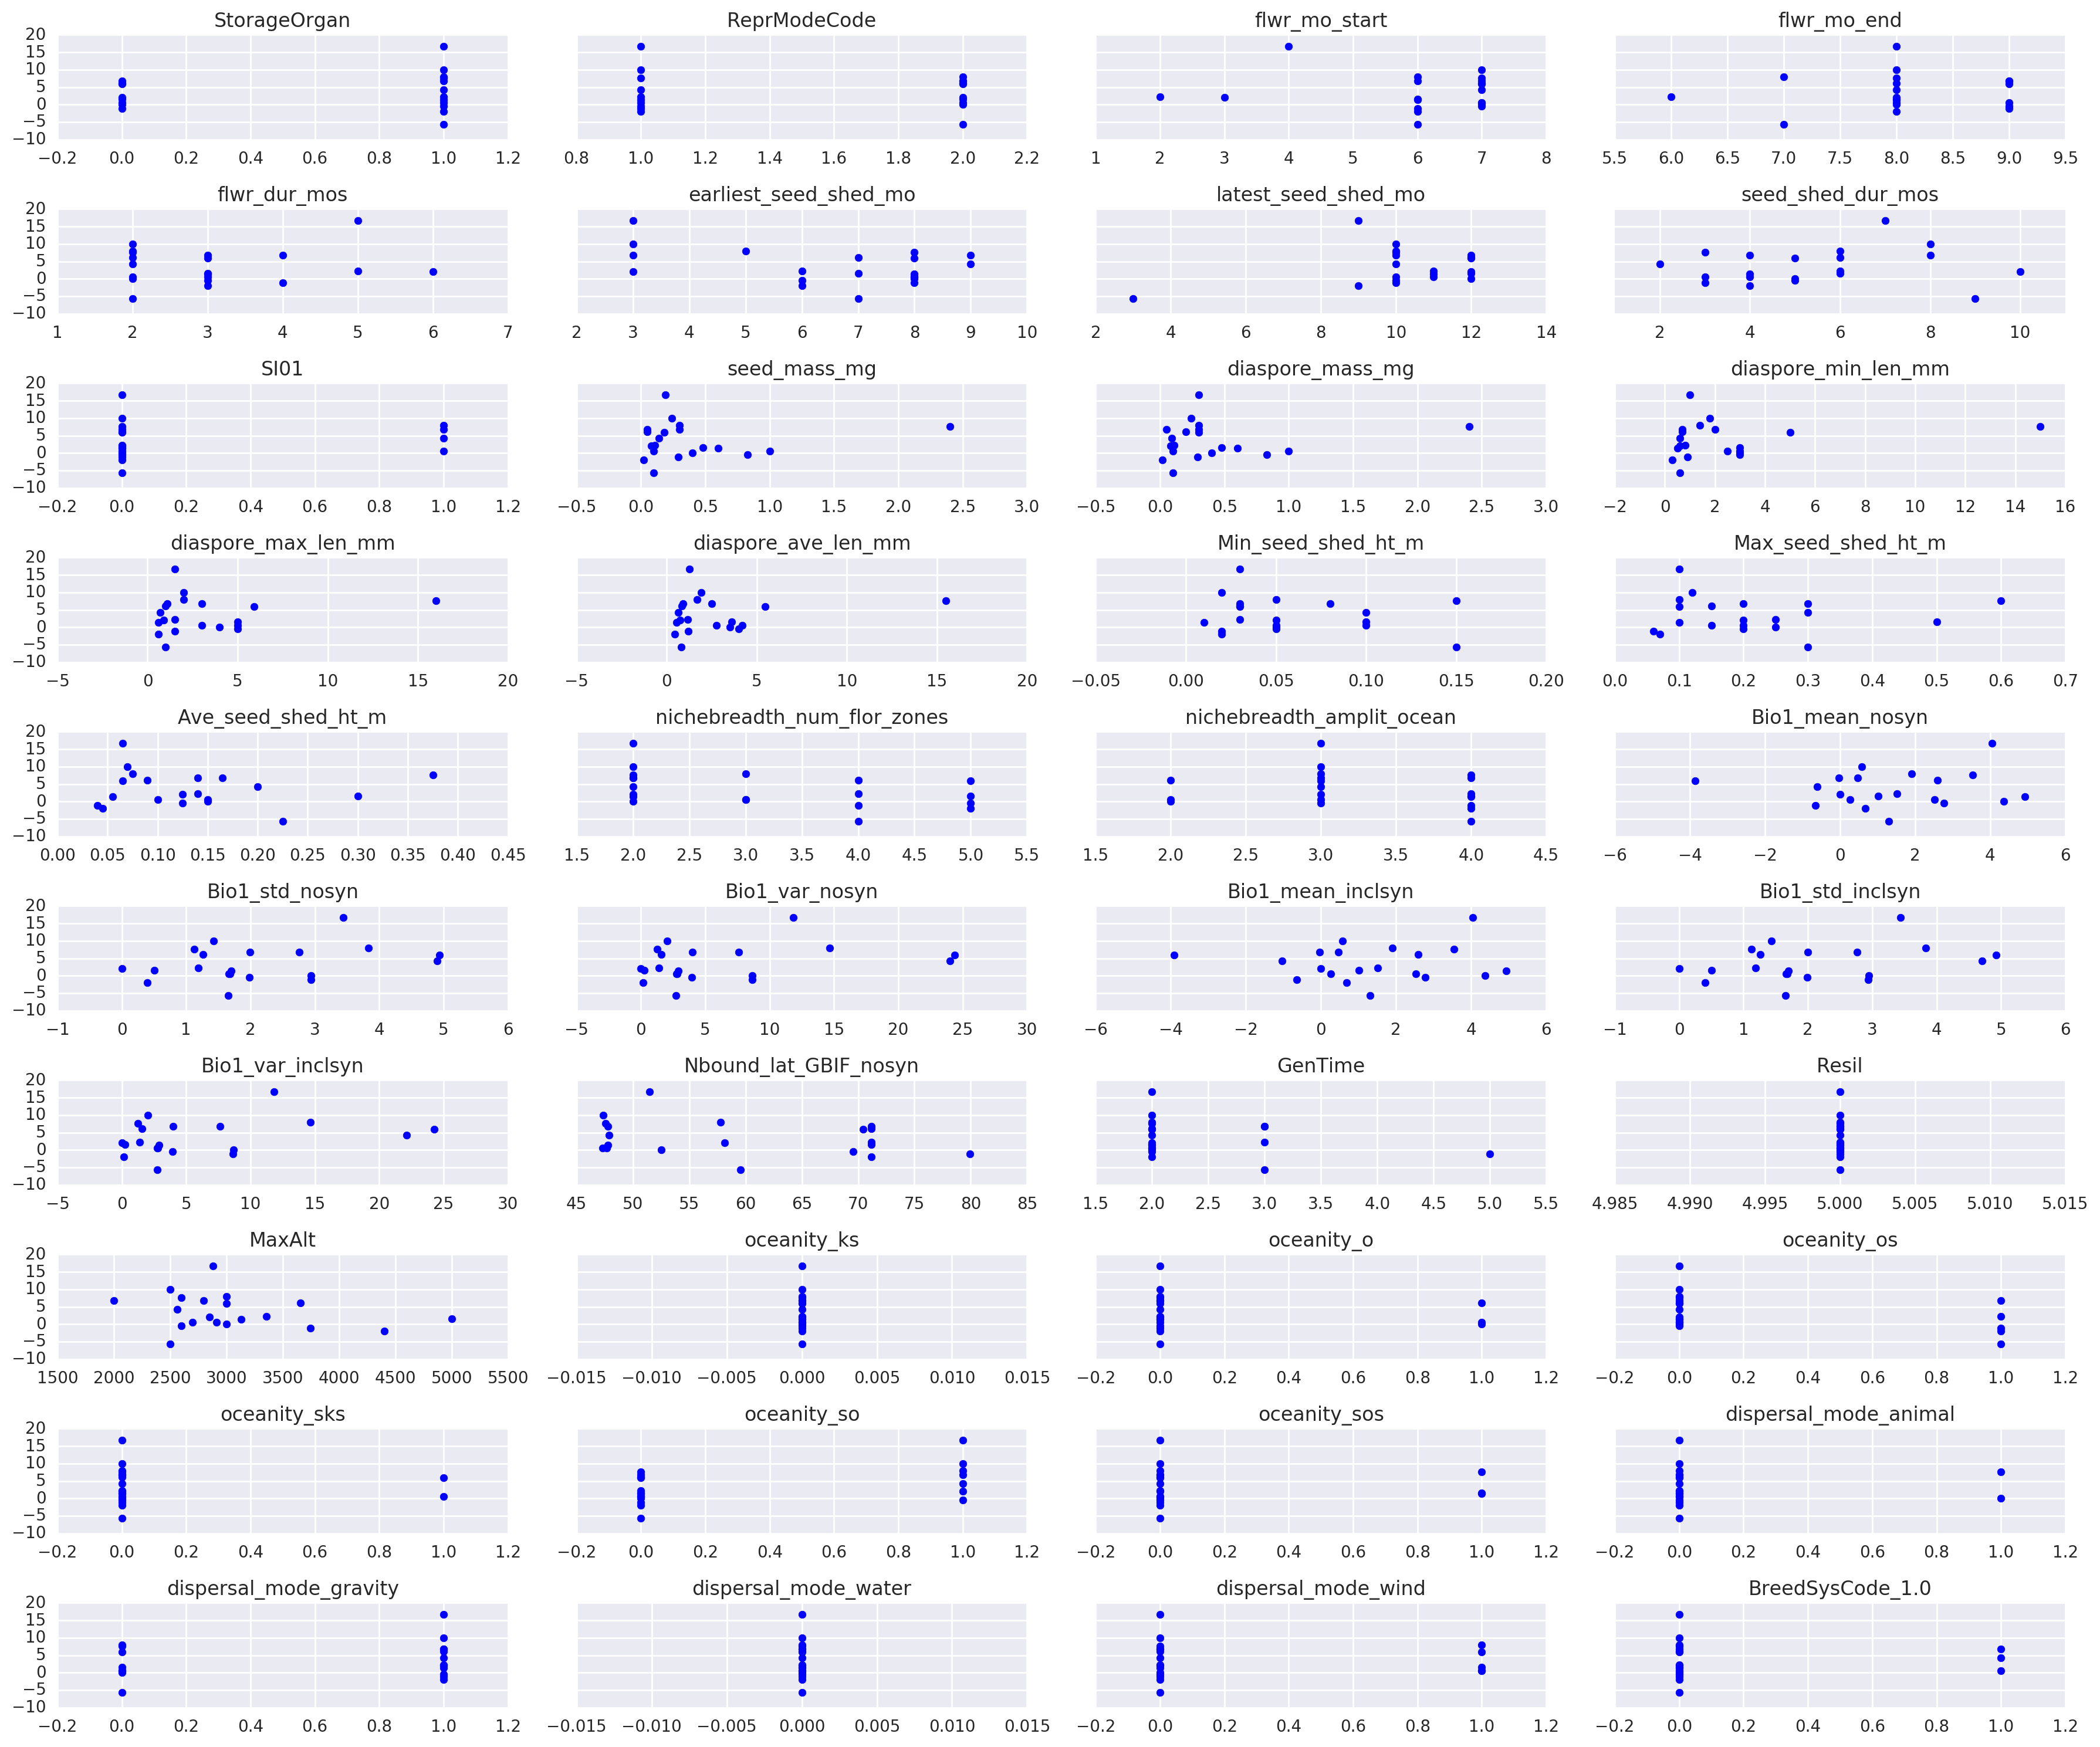

In [93]:
fig, subplots = plt.subplots(10,4, sharey=True)
fig.set_figwidth(18)
fig.set_figheight(15)
featureIter = iter(features.columns)

for row in range(0, 10):
    for col in range(0, 4):
        try:
            feat = next(featureIter)
            X = features[feat].values.reshape(-1,1)
            Y = target
            subplots[row, col].scatter(X, Y, color='blue')
            subplots[row, col].set_title(str(feat))
        except StopIteration:
            fig.delaxes(subplots[row,col])
                    

plt.tight_layout()
plt.show()



---
# Principal Component Analysis
We begin with a short PCA on these data and an examination of the linear regression coefficients for each component to identify axes with high variance. To do this, we should *scale the data first*. 

In [28]:
from sklearn.preprocessing import StandardScaler, normalize
scaler = StandardScaler().fit(features)
features_scaled = scaler.transform(features)

In [31]:
from sklearn.decomposition import PCA

PCA_All  = PCA()
PCA_95   = PCA(n_components=0.95, svd_solver='full') ## computes components necessary to explain 95% of variance

PCA_All.fit(features_scaled), PCA_95.fit(features_scaled)

(PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
   svd_solver='full', tol=0.0, whiten=False))

We can make scree plots: 

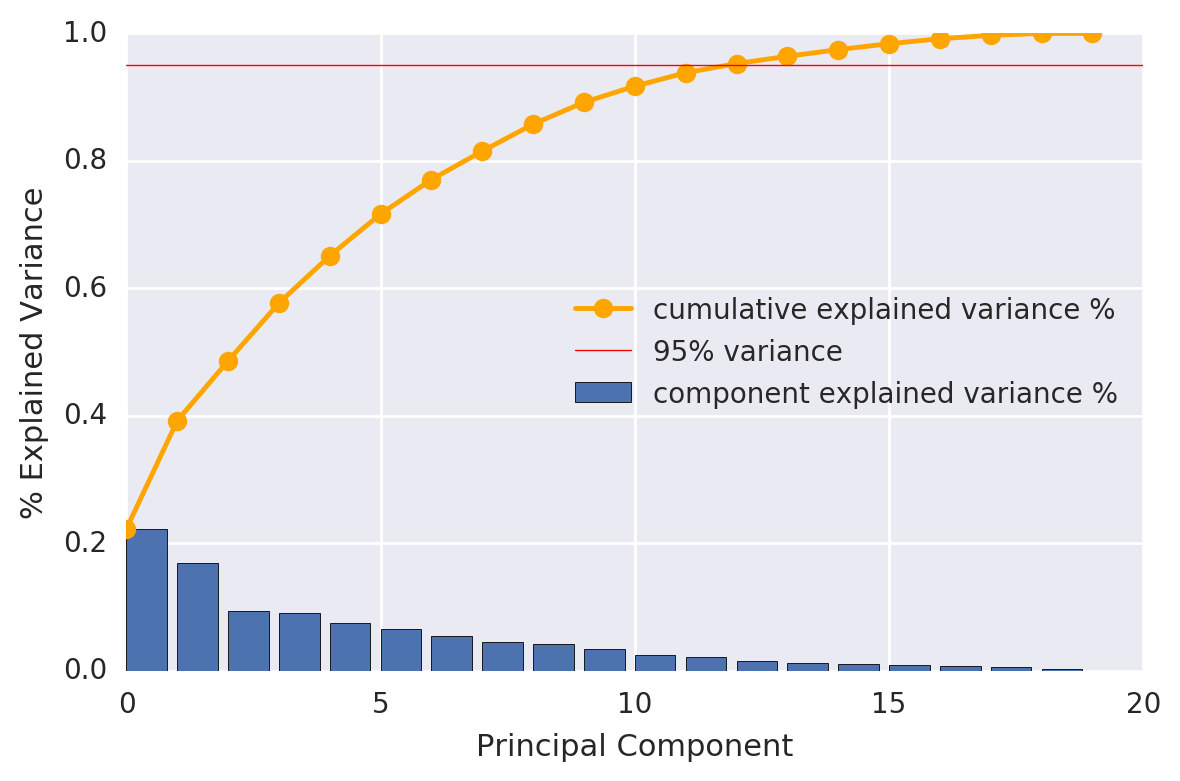

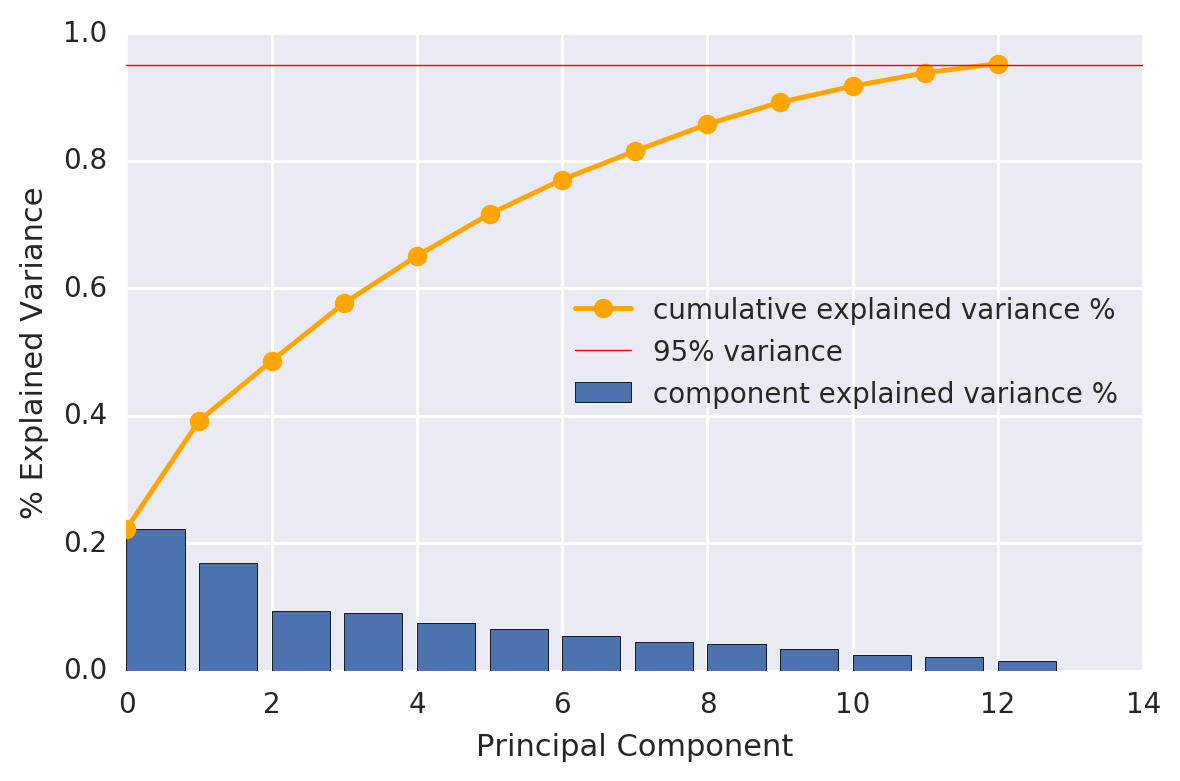

In [52]:
PCA_All_expvar = PCA_All.explained_variance_ratio_
PCA_95_expvar  = PCA_95.explained_variance_ratio_


plt.bar(left=range(0, len(PCA_All_expvar)), height=PCA_All_expvar, label='component explained variance %')
plt.xlabel("Principal Component")
plt.ylabel("% Explained Variance")
plt.plot(np.cumsum(PCA_All_expvar), '-o', color='orange', label="cumulative explained variance %")
plt.axhline(y=0.95, linewidth=0.5, color='red', label="95% variance")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

plt.bar(left=range(0, len(PCA_95_expvar)), height=PCA_95_expvar, label='component explained variance %')
plt.xlabel("Principal Component")
plt.ylabel("% Explained Variance")
plt.plot(np.cumsum(PCA_95_expvar), '-o', color='orange', label="cumulative explained variance %")
plt.axhline(y=0.95, linewidth=0.5, color='red', label="95% variance")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [54]:
coefs = pd.DataFrame(PCA_All.components_.T,
                     columns = ["PC:"+str(x) for x in range(0, len(PCA_All.components_))], # label components
                     index=features.columns)

In [64]:
pd.DataFrame(list(zip(coefs.columns, coefs.abs()[:].idxmax(),coefs.abs()[:].max(), coefs[:].abs().mean())), 
            columns= ['PC', "Strongest (Abs) Linear Correlation Variable", "Max coefficient", "Mean coefficient for PC"], 
            index=coefs.columns
            )

,PC,Strongest (Abs) Linear Correlation Variable,Max coefficient,Mean coefficient for PC
PC:0,PC:0,seed_mass_mg,0.291841,0.106993
PC:1,PC:1,Bio1_var_nosyn,0.267704,0.116387
PC:2,PC:2,StorageOrgan,0.344095,0.111749
PC:3,PC:3,Nbound_lat_GBIF_nosyn,0.289100,0.111855
PC:4,PC:4,BreedSysCode_1.0,0.353582,0.101446
PC:5,PC:5,latest_seed_shed_mo,0.369164,0.105289
PC:6,PC:6,earliest_seed_shed_mo,0.323202,0.106939
PC:7,PC:7,dispersal_mode_wind,0.411079,0.108023
PC:8,PC:8,dispersal_mode_animal,0.348597,0.112494
PC:9,PC:9,BreedSysCode_3.0,0.424294,0.100979


# Pearson's $r$
Back to basics here. How linear is the relationship?


In [105]:
from scipy.stats import pearsonr

rs = list()
for feature in features:
    r = pearsonr(features[feature], target)
    rs.append(r)

rs = pd.DataFrame(rs, index=features.columns, columns=["Pearson R", "$p$-value"])
rs = rs.reindex(rs["Pearson R"].abs().sort(inplace=False).index)
rs

/opt/conda/lib/python3.5/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


,Pearson R,$p$-value
oceanity_sos,-0.004286,0.985693
dispersal_mode_animal,0.017003,0.943279
oceanity_sks,-0.020404,0.931958
dispersal_mode_wind,-0.027094,0.909724
BreedSysCode_1.0,0.029999,0.900088
Grime_cs,0.044208,0.853179
Max_seed_shed_ht_m,-0.044754,0.851383
BreedSysCode_2.0,0.050654,0.832043
Grime_s,0.055656,0.815720
flwr_mo_end,0.062424,0.793748


Get the lowest 10:

In [118]:
rs.head(10)

,Pearson R,$p$-value
oceanity_sos,-0.004286,0.985693
dispersal_mode_animal,0.017003,0.943279
oceanity_sks,-0.020404,0.931958
dispersal_mode_wind,-0.027094,0.909724
BreedSysCode_1.0,0.029999,0.900088
Grime_cs,0.044208,0.853179
Max_seed_shed_ht_m,-0.044754,0.851383
BreedSysCode_2.0,0.050654,0.832043
Grime_s,0.055656,0.815720
flwr_mo_end,0.062424,0.793748


## Non-categorical analysis

We should probably also do this analysis with the categorical features totally removed (no one-hot encoding). 

In [125]:
noncatFeatures = plants_master.drop(drop_features + categorical_features, axis=1)

# drop features with n/a or NaN
beforenona = set(noncatFeatures.columns.values)
## axis = 1 drops columns with any NAs, axis = 0 drops rows with any NAs
noncatFeatures = noncatFeatures.dropna(axis=DROP_FEATS)
afternona  = set(noncatFeatures.columns.values)

# extract response variable from trimmed data
noncattarget   = noncatFeatures["migration_m"]
noncatFeatures.drop(["migration_m"], inplace=True, axis=1)

rsnoncat = list()
for feature in noncatFeatures:
    r = pearsonr(noncatFeatures[feature], target)
    rsnoncat.append(r)
    
rsnoncat = pd.DataFrame(rsnoncat, index=noncatFeatures.columns, columns=["Pearson R", "$p$-value"])
rsnoncat = rsnoncat.reindex(rsnoncat["Pearson R"].abs().sort(inplace=False).index)
rsnoncat.head(10)


/opt/conda/lib/python3.5/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


,Pearson R,$p$-value
Max_seed_shed_ht_m,-0.044754,0.851383
flwr_mo_end,0.062424,0.793748
ReprModeCode,-0.069373,0.771344
Bio1_mean_inclsyn,0.074047,0.756371
seed_mass_mg,0.074466,0.755030
Bio1_mean_nosyn,0.077278,0.746068
flwr_mo_start,-0.078587,0.741906
Ave_seed_shed_ht_m,-0.085435,0.720244
diaspore_mass_mg,0.115906,0.626531
seed_shed_dur_mos,0.130723,0.582776


# Are the data normal? <small> will linear regression work?</small>

We use the Kolmogorov-Smirnov Goodness-of-Fit Test. 

In [114]:
from scipy.stats import norm, kstest

ks = list()
for feature in features.columns.values:
    ks.append(kstest(features[feature], 'norm'))
    
ks = pd.DataFrame(ks, index=features.columns)
ks = ks.sort(columns=["statistic"])

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Get the worst 10 here too (closest to 1): 

In [115]:
ks.tail(10)

,statistic,pvalue
seed_shed_dur_mos,0.97725,0.0
flwr_dur_mos,0.97725,0.0
flwr_mo_start,0.97725,0.0
nichebreadth_num_flor_zones,0.97725,0.0
latest_seed_shed_mo,0.99865,0.0
earliest_seed_shed_mo,0.99865,0.0
Resil,1.00000,0.0
flwr_mo_end,1.00000,0.0
MaxAlt,1.00000,0.0
Nbound_lat_GBIF_nosyn,1.00000,0.0
